<a href="https://colab.research.google.com/github/fabioc99/Computer-vision/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[image]
!pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytorch_fid.fid_score import calculate_fid_given_paths
from torchmetrics.image.fid import FrechetInceptionDistance

In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import matplotlib.pyplot as plt
import datetime
import os
from torchvision.datasets import ImageFolder



In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

batch_size = 18

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/mani', transform=train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

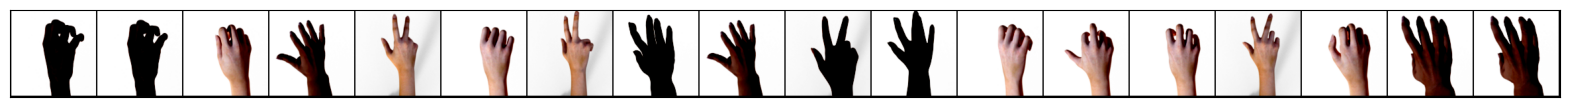

In [ ]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break
        
show_batch(train_loader)

In [8]:
image_shape = (3, 128, 128)
image_dim = int(np.prod(image_shape)) #calculates the total number of elements in an image by taking the product of all dimensions
latent_dim = 100 #dimensionality of the latent space,  higher values of latent_dim can potentially capture more detailed information
n_classes = 3
embedding_dim = 100  # ogni classe sarà rappresentata da un vettore di lunghezza 100

In [5]:
# custom weights initialization called on generator and discriminator
def weights_init(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
     #label_conditioned_generator è un modulo sequenziale che consiste in un'operazione di embedding seguita 
     #da un layer lineare. L'operazione di embedding converte la label condizionale in un vettore di dimensione embedding_dim, 
     #mentre il layer lineare trasforma tale vettore in un output di dimensione 16.
        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16)) #La scelta di una dimensione di output di 16 nel layer lineare dipende dall'idea di ridurre la dimensione della rappresentazione.
        
       #latent è un modulo sequenziale che consiste in un layer lineare seguito da una funzione di attivazione LeakyReLU. 
       #Il layer lineare prende in input il rumore casuale (vettore di dimensione latent_dim) e lo trasforma in un output
       #di 512 elementi. La LeakyReLU è una funzione di attivazione che introduce un leggero "leak" 
       #nella regione negativa, aiutando a prevenire il problema del "neurone morto" durante l'addestramento (se un neurone ha inizialmente dei pesi 
       #molto piccoli o molto grandi, l'output prodotto dal neurone potrebbe essere molto vicino a zero, e la funzione di attivazione (come la ReLU) 
       #potrebbe annullare o saturare l'output, rendendo il neurone "morto" e incapace di apprendere)
        self.latent = nn.Sequential(nn.Linear(latent_dim, 1024),
                                   nn.LeakyReLU(0.2, inplace=True))
           
       #model è un modulo sequenziale che implementa la parte convoluzionale del generatore. 
       #il primo ConvTranspose2d  è un layer di convoluzione trasposta che diminuisce la dimensione dello spazio latente iniziale (512) 
       #a 64*8 volte la dimensione originale. Viene utilizzato un kernel di dimensione 4x4, uno stride di 2 e un padding di 1. 
       #Non viene utilizzato alcun bias nel calcolo.
        self.model = nn.Sequential(nn.ConvTranspose2d(1024, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), #True indica che ReLU viene applicato in-place, sovrascrivendo l'input.
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 64*1, 4, 2, 1,bias=False),
                      nn.BatchNorm2d(64*1, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      #Questo è l'ultimo layer di convoluzione trasposta che converte l'output del generatore in un'immagine a colori con 3 canali 
                      nn.ConvTranspose2d(64*1, 3, 4, 2, 1, bias=False),
                      nn.Tanh())
        
    #Nella funzione forward, vengono passati due input: il rumore casuale (noise_vector) e la label condizionale (label).
    # La label condizionale viene elaborata dal label_conditioned_generator e successivamente viene ridimensionata in un 
    #tensore 4x4 tramite label_output.view(-1, 1, 4, 4). Il rumore casuale viene elaborato dal latent e anch'esso viene 
    #ridimensionato in un tensore di dimensione 512x4x4 tramite latent_output.view(-1, 512, 4, 4). Infine, i due tensori
    # vengono concatenati lungo la dimensione del canale e passati al modulo model per generare l'immagine sintetica finale,
    # che viene restituita come output della funzione.
    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512,4,4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        #print(image.size())
        return image

In [22]:
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(3, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_s

In [ ]:
a = torch.ones(100)
b = torch.ones(1)
b = b.long() #Questa operazione è eseguita per assicurarsi che b sia un tensore di numeri interi anziché un tensore di numeri in virgola mobile.
a = a.to(device)
b = b.to(device)
c = generator((a,b)) #Passa i tensori a e b come input al generatore per generare un'immagine sintetica.
c.size() # Restituisce la dimensione dell'output c, che è un tensore rappresentante un'immagine sintetica. 

torch.Size([1, 3, 128, 128])

In [38]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #prende un'etichetta come input e restituisce un tensore di dimensione 3*128*128. 
        #Questo tensore rappresenta una rappresentazione densa dell'etichetta, in cui l'etichetta 
        #è stata convertita in un vettore di dimensione 3*128*128.
        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*128*128))
        
         #modulo sequenziale che comprende una serie di layer convoluzionali, 
         #normalizzazione del batch, attivazioni LeakyReLU, dropout e layer lineari.
         # Il primo layer convoluzionale prende in input un tensore di
         #dimensione 64 e produce un'immagine con 128
         #canali utilizzando un kernel di dimensione 4x4, uno stride di 3, zero padding di 2 
         # e senza bias ( bias è un parametro aggiuntivo utilizzato nei layer convoluzionali per aggiungere un termine costante ai valori di output). 
         #L'attivazione LeakyReLUviene applicata dopo questo layer.    
        self.model = nn.Sequential(nn.Conv2d(64, 64*2, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 3,2, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*4, 64*8, 4, 3, 2, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(), #Questo layer trasforma l'output del layer convoluzionale in un vettore piatto, preparandolo per i layer lineari successivi.
                      nn.Dropout(0.4),
                      nn.Linear(4608, 1), # prende in input un vettore di dimensione 4608 (ottenuto dal flatten) e produce un singolo valore di output.
                      nn.Sigmoid()  #restituisce un valore compreso tra 0 e 1 che rappresenta la probabilità che l'immagine in input sia reale o sintetica.
                     )
    #Questo metodo definisce come i tensori di input vengono propagati attraverso la rete del discriminatore
    def forward(self, inputs):
        img, label = inputs #input vengono scomposti in img (immagine) e label (etichetta).
        label_output = self.label_condition_disc(label) # L'etichetta viene passata attraverso il modulo label_condition_disc per ottenere una rappresentazione densa dell'etichetta.
        label_output = label_output.view(-1, 3, 128, 128)  #La rappresentazione densa dell'etichetta viene ridimensionata per avere le dimensioni di un'immagine RGB di 128x128.
        concat = torch.cat((img, label_output), dim=1) #L'immagine img e la rappresentazione dell'etichetta label_output vengono concatenate lungo la dimensione dei canali (dimensione 1).
        #print(concat.size())
        output = self.model(concat) # Il tensore concatenato viene passato attraverso il modulo model che esegue l'elaborazione delle immagini e produce l'output finale del discriminatore.
        return output  # L'output del discriminatore, che rappresenta la probabilità che l'immagine in input sia reale o sintetica, viene restituito.

In [39]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(3, 100)
    (1): Linear(in_features=100, out_features=49152, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(3, 3), padding=(2, 2), bias=False)
    (7): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Dropout(p=0.4, inplace=False)
    (11): Linear(in_features=4608, out_features=1, bias=Tr

In [ ]:
#prova se funziona passando una immagine
a = torch.ones(1,3,128,128)
b = torch.ones(1,1)
b = b.long()
a = a.to(device)
b = b.to(device)
c = discriminator((a,b))
c.size()  #output 1 immagine, 1 output

torch.Size([1, 1])

In [ ]:
adversarial_loss = nn.BCELoss() 

#calcola la perdita del generatore utilizzando l'output generato dal generatore (fake_output) e le etichette di riferimento (label).
#la perdita del generatore viene calcolata in base a quanto bene l'output falso del generatore riesce a "ingannare" il discriminatore.
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    return gen_loss

#calcola la perdita del discriminatore utilizzando l'output del discriminatore (output) e le etichette di riferimento (label).
#Pertanto, la perdita del discriminatore viene calcolata in base a quanto bene il discriminatore è in grado di distinguere tra le due categorie.
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

learning_rate = 0.0002 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [ ]:
num_epochs = 100
D_loss_plot, G_loss_plot = [], []
fid_scores = [] 

unique_labels = list(range(len(train_dataset.classes))) # elenco contenente etichette. Questo è probabilmente necessario per generare le etichette delle immagini generate.

for epoch in range(1, num_epochs+1): 

    D_loss_list, G_loss_list = [], [] #liste per memorizzare le perdite
    
    # viene iterato attraverso il train_loader, che fornisce i dati di
    # addestramento suddivisi in batch. Viene estratto ogni batch contenente
    # immagini reali (real_images) e le rispettive etichette (labels).
    for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()  #Vengono azzerati i gradienti dell'ottimizzatore del discriminatore 
        real_images = real_images.to(device) #Le immagini reali vengono spostate
        labels = labels.to(device) #Le etichette vengono spostate
        labels = labels.unsqueeze(1).long() #viene effettuata una trasformazione per espandere le dimensioni delle etichette

        #Vengono creati due tensori di target per calcolare le perdite discriminatorie.
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device)) #real_target contenente valori di 1 per le immagini reali
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device)) #fake_target contenente valori di 0 per le immagini generate
      
        #Viene calcolata la perdita discriminatoria per le immagini reali,
        # L'output del discriminatore per le immagini reali viene passato alla 
        #funzione di perdita discriminatoria (discriminator_loss) insieme al target corrispondente.
        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        
        #Viene generato un vettore di rumore (noise_vector) campionato casualmente dalla
        # distribuzione normale e spostato sulla GPU. Questo vettore di rumore sarà utilizzato
        # per generare immagini sintetiche.
        noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
        noise_vector = noise_vector.to(device)
        
        #Il generatore viene chiamato passando il vettore di rumore e le etichette corrispondenti 
        #per generare le immagini sintetiche 
        generated_image = generator((noise_vector, labels))
        
        #viene calcolato l'output del discriminatore per le immagini generate 
        output = discriminator((generated_image.detach(), labels))
        #viene calcolata la perdita discriminatoria per le immagini generate
        D_fake_loss = discriminator_loss(output,  fake_target)

        #Viene calcolata la perdita discriminatoria totale come la media delle perdite per le immagini reali e le immagini generate
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)
      
        D_total_loss.backward() #retropropagazione del gradiente per il discriminatore
        D_optimizer.step() #l'ottimizzatore del discriminatore viene aggiornato 

        # Si passa ora all'addestramento del generatore. 
        G_optimizer.zero_grad() #Si azzerano i gradienti dell'ottimizzatore del generatore
        # Viene calcolata la perdita generativa utilizzando l'output del discriminatore per le immagini generate e il target delle immagini reali.
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward() #retropropagazione del gradiente per il generatore
        G_optimizer.step() #si aggiorna l'ottimizzatore del generatore

    #Viene calcolata la media delle perdite discriminatorie e generative 
    #e vengono stampate durante l'epoca corrente.
    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
             torch.mean(torch.FloatTensor(G_loss_list))))
    
    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))

    #Viene calcolato il punteggio FID tra le immagini sintetiche generate e un set di validazione. 
    fid = calculate_fid_given_paths(['/content/drive/MyDrive/validation','/content/torch/images/mani_generate3'], dims=2048, device = device, batch_size=16)
    fid_scores.append(fid)
    shutil.rmtree('/content/torch/images/mani_generate3')

    # Ottieni le etichette testuali corrispondenti alle etichette generate
    label_names = [train_dataset.classes[label] for label in generated_labels]

    # Salva le immagini generate con le etichette appropriate
    for i in range(generated_image.size(0)):
        save_path = os.path.join(save_dir, f'sample_{epoch}_label_{label_names[i]}.png')
        save_image(generated_image[i], save_path, normalize=True)

    #il modello generatore e il modello discriminatore vengono salvati
    save_dir = 'torch/training_weights'
    os.makedirs(save_dir, exist_ok=True)
    torch.save(generator.state_dict(), 'torch/training_weights/generator_epoch_%d.pth' % (epoch))
    torch.save(discriminator.state_dict(), 'torch/training_weights/discriminator_epoch_%d.pth' % (epoch))

Epoch: [1/100]: D_loss: 0.292, G_loss: 3.960
Epoch: [2/100]: D_loss: 0.203, G_loss: 3.781
Epoch: [3/100]: D_loss: 0.249, G_loss: 3.789
Epoch: [4/100]: D_loss: 0.209, G_loss: 4.081
Epoch: [5/100]: D_loss: 0.237, G_loss: 4.025
Epoch: [6/100]: D_loss: 0.263, G_loss: 3.963
Epoch: [7/100]: D_loss: 0.268, G_loss: 3.782
Epoch: [8/100]: D_loss: 0.287, G_loss: 3.930
Epoch: [9/100]: D_loss: 0.270, G_loss: 3.602
Epoch: [10/100]: D_loss: 0.300, G_loss: 3.699
Epoch: [11/100]: D_loss: 0.244, G_loss: 3.642
Epoch: [12/100]: D_loss: 0.268, G_loss: 3.861
Epoch: [13/100]: D_loss: 0.267, G_loss: 3.891
Epoch: [14/100]: D_loss: 0.276, G_loss: 4.029
Epoch: [15/100]: D_loss: 0.335, G_loss: 3.396
Epoch: [16/100]: D_loss: 0.269, G_loss: 3.708
Epoch: [17/100]: D_loss: 0.262, G_loss: 3.814


KeyboardInterrupt: ignored

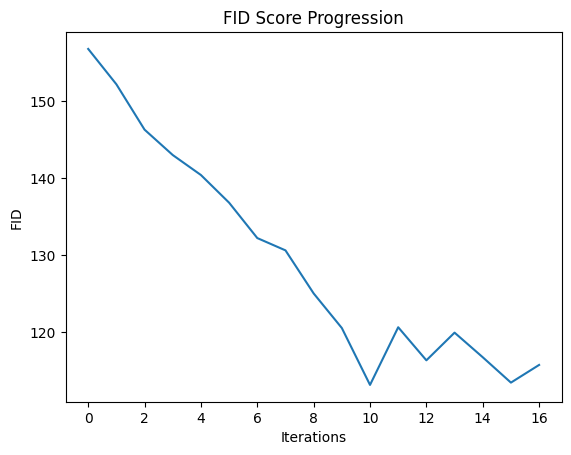

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fid_scores)
plt.xlabel('Iterations')
plt.ylabel('FID')
plt.title('FID Score Progression')
plt.show()


**Classification** 

(il seguente codici è stato usato due volte con due dataset diversi: il primo conteneva solamente le immagini del dataset originale, mentre nel secondo sono state aggiunte le immagini generate )


In [24]:
#caricare il dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# Definisci le trasformazioni da applicare alle immagini
transforms = transforms.Compose([
         transforms.Resize(64),
         transforms.CenterCrop(64),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


#dataset
dataset = ImageFolder('/content/drive/MyDrive/mani', transform=transforms)

In [25]:
#creare train set e test set 
from torch.utils.data import random_split

# Definisci la proporzione del set di test
test_size = 0.2

# Calcola le dimensioni del set di test e di training
num_data = len(dataset)
num_test_data = int(num_data * test_size)
num_train_data = num_data - num_test_data

# Suddividi il dataset in set di training e test
train_set, test_set = random_split(dataset, [num_train_data, num_test_data])

# Crea i dataloader per il set di training e di test
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=True)

In [26]:
import torch.nn as nn

class SeqCNN(nn.Module):

  # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2, stride=1, dilation=1, padding_mode='zeros'),  
        nn.BatchNorm2d(16),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros' ),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(64), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [27]:
# Create the model
seq_net = SeqCNN()
print(seq_net)

SeqCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [28]:
# Get an element from the dataset
img_x, _ = train_set[0] # [0]: each element of the dataset is a couple (image, label)
# Get the size of a sample
img_x.size()

torch.Size([3, 64, 64])

In [29]:
img_x = img_x.unsqueeze(dim=0) #aggiungere una dimensione
img_x.size()

torch.Size([1, 3, 64, 64])

In [30]:
#applichiamo il modello convolutional layers
output = seq_net(img_x) #output per un'immagine 
output.shape

torch.Size([1, 64, 16, 16])

In [31]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

16384


In [32]:
class CNN(nn.Module):

 # Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2, stride=1, dilation=1, padding_mode='zeros' ),  
        nn.BatchNorm2d(16), # Add Batch Normalization
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(32), # Add Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1, dilation=1, padding_mode='zeros'),
        nn.BatchNorm2d(64), # Add Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(16384, 512), #input and output neurons
        nn.ReLU(),
        # the final Classification Layer
        nn.Linear(512, 3)  #input and output neurons
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)     # x has size [batch_size, num_filters, height, width] before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1)  # now x has size [batch_size, num_features]
    output = self.fc_layers(x) #  --> [B, 2]
    return output

In [33]:
# Create the model
model = CNN()
print(model)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [34]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.03)
# Define a loss 
criterion = nn.CrossEntropyLoss()

import torch
dev = torch.device('cpu')

In [35]:
import matplotlib.pyplot as plt

def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "test": []}
        history_accuracy = {"train": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "test": 0}
            sum_accuracy = {"train": 0, "test": 0}
            # Process each split
            for split in ["train", "test"]:
                if split == "train":
                    net.train()
                else:
                    net.eval()
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to Cpu
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    outputs = net(input)
                    loss = criterion(outputs, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    preds = torch.argmax(outputs, 1)
                    batch_accuracy = (preds == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "test"]}
            # Update history
            for split in ["train", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [36]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "test": test_loader}


CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
  )
)
Epoch 1: TrL=0.7125, TrA=0.8139, TeL=0.0237, TeA=1.0000,
Epoch 2: TrL=0.0088, TrA=

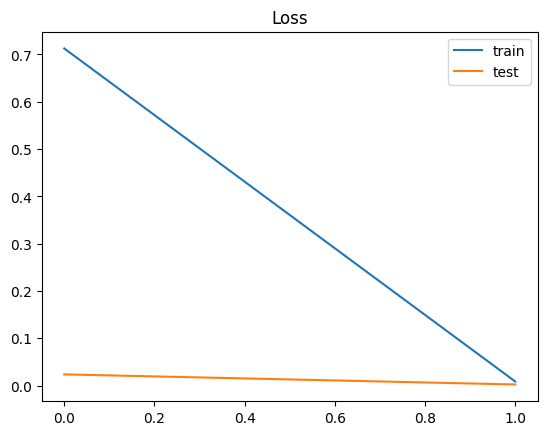

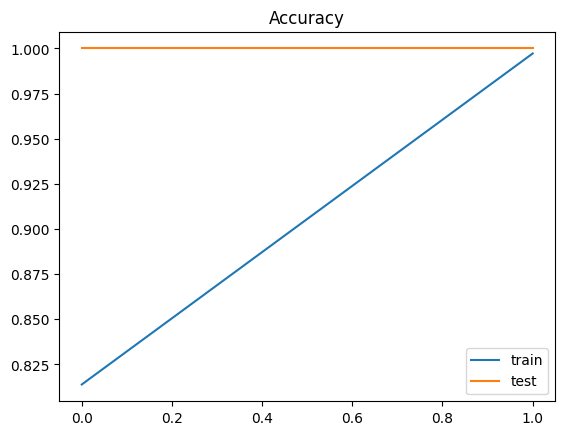

In [37]:
# Train model
train(model, loaders, optimizer, criterion, epochs=8, dev=dev)